In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, sampler
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Only run once, don't rerun in same runtime
%cd /content/drive/My\ Drive/DeepAdDetection/

%ls
!pwd


/content/drive/My Drive/DeepAdDetection
data-new/  test/  Train2.ipynb  TransferLearning.ipynb
/content/drive/My Drive/DeepAdDetection


In [3]:
device = torch.device("cuda" if torch.cuda.is_available()
                               else "cpu")
print("We are using: ", device)

We are using:  cuda


In [5]:
img_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

data = datasets.ImageFolder(root ="/content/drive/My Drive/DeepAdDetection/data-new",  transform = img_transforms)


data_indices = list(range(len(data)))[:16696] # class imbalance bc 8348 ads and 13597 non ads, so we resize to 8348 ads and 8348 nonads
# ad, non_ad = data_indices[:8348], data_indices[8348:]
# data_indices = ad[:5000] + non_ad[:5000] 

print(len(data_indices))
np.random.shuffle(data_indices)
print(data_indices[:100])
# 70/15/15 split for train/val/test
val_split_index = len(data_indices) - int(np.floor(0.30 * len(data_indices)))
test_split_index = len(data_indices) - int(np.floor(0.15 * len(data_indices)))

print("val split index: ", val_split_index)
print("test_split_index: ", test_split_index)

train_idx = data_indices[: val_split_index]
val_idx = data_indices[val_split_index: test_split_index]
test_idx = data_indices[test_split_index:]

print("len train: ", len(train_idx))
print("len val: ", len(val_idx))
print("len test: ", len(test_idx))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset=data, shuffle=False, batch_size=64, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset=data, shuffle=False, batch_size=64, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(dataset=data,shuffle=False, batch_size=64, sampler=test_sampler, num_workers=4)

data.class_to_idx.items()


16696
[2228, 7175, 9725, 10785, 12767, 6184, 14123, 5089, 81, 14174, 464, 5392, 1183, 308, 4491, 2482, 7802, 13165, 6294, 12744, 9063, 7602, 11349, 16490, 11406, 10400, 11022, 8612, 13432, 2352, 1426, 15483, 15333, 1172, 5206, 4924, 15681, 7700, 14393, 14127, 8250, 5196, 5143, 6321, 13458, 10032, 14006, 16180, 12347, 14562, 9345, 4840, 8321, 10385, 689, 2834, 10209, 5312, 234, 4475, 8525, 13943, 11019, 3771, 3181, 11952, 8959, 7861, 13311, 11614, 15653, 797, 6991, 11575, 9951, 5425, 1012, 9583, 1914, 8848, 15692, 5380, 13265, 1975, 4788, 12454, 15005, 471, 390, 1011, 1663, 954, 7902, 3643, 15430, 2930, 15688, 7373, 6201, 8175]
val split index:  11688
test_split_index:  14192
len train:  11688
len val:  2504
len test:  2504


dict_items([('ad', 0), ('not-ad', 1)])

In [0]:
# # model = models.resnet34(pretrained=True) # resnet34
# model = models.resnet101(pretrained=True) # resnet 101

# for param in model.parameters():
#     param.requires_grad = False

# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#                       nn.Linear(num_ftrs, 256), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.5),
#                       nn.Linear(256, 2),                   
#                       nn.LogSoftmax(dim=1))




In [0]:
# # Inception (no linear layer, so we replace last conv layer w right number of classes)
# # change the last conv2d layer
# model = models.inception_v3(pretrained=True)
# print(model) 
# # model.classifier._modules["1"] = nn.Conv2d(512, 2, kernel_size=(1, 1))
# # # change the internal num_classes variable rather than redefining the forward pass
# # model.num_classes = 2


In [6]:
# Squeezenet (no linear layer, so we replace last conv layer w right number of classes)
# change the last conv2d layer
model = models.squeezenet1_0(pretrained=True) 
model.classifier._modules["1"] = nn.Conv2d(512, 2, kernel_size=(1, 1))
# change the internal num_classes variable rather than redefining the forward pass
model.num_classes = 2

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.0095, momentum=0.9)

In [0]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [0]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [10]:
print("Begin training.")

for e in tqdm(range(15)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        print(i, len(train_loader), train_epoch_loss, train_epoch_acc)
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        j = 0
        for X_val_batch, y_val_batch in val_loader:
            j += 1
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            # y_val_pred = model(X_val_batch).squeeze()
            # y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
            print(j, len(val_loader), val_epoch_loss, val_epoch_acc)

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


0 183 0.7760359048843384 53.0
1 183 1.516990602016449 109.0
2 183 2.4146962761878967 156.0
3 183 3.043927311897278 225.0
4 183 3.7177035808563232 283.0
5 183 4.4355592131614685 336.0
6 183 5.055980324745178 408.0
7 183 5.710914254188538 477.0
8 183 6.300942659378052 555.0
9 183 7.052158534526825 608.0
10 183 7.723730623722076 667.0
11 183 8.381697714328766 725.0
12 183 9.08269476890564 775.0
13 183 9.734204888343811 825.0
14 183 10.424442946910858 873.0
15 183 11.057568430900574 931.0
16 183 11.713064968585968 993.0
17 183 12.361350953578949 1046.0
18 183 12.999460995197296 1096.0
19 183 13.677153527736664 1140.0
20 183 14.325317859649658 1188.0
21 183 14.990380048751831 1244.0
22 183 15.662751138210297 1300.0
23 183 16.27157413959503 1364.0
24 183 16.909712731838226 1419.0
25 183 17.62773859500885 1472.0
26 183 18.300119161605835 1525.0
27 183 18.90751850605011 1594.0
28 183 19.542625665664673 1666.0
29 183 20.236947417259216 1727.0
30 183 20.88122534751892 1797.0
31 183 21.5025400519

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

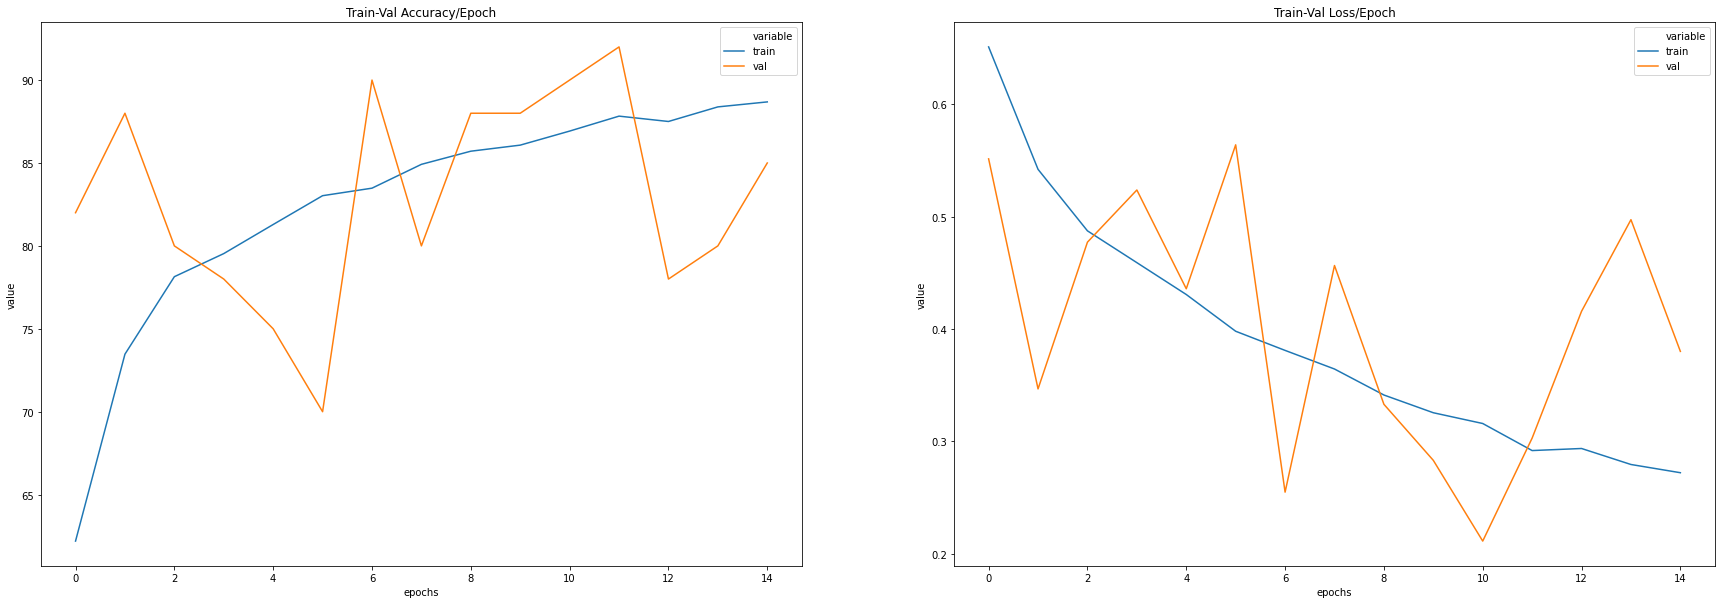

In [11]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [12]:
test_loader = DataLoader(dataset=data,shuffle=False, batch_size=1, sampler=test_sampler)
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1252
           1       0.84      0.79      0.81      1252

    accuracy                           0.82      2504
   macro avg       0.82      0.82      0.82      2504
weighted avg       0.82      0.82      0.82      2504

[[1057  195]
 [ 258  994]]


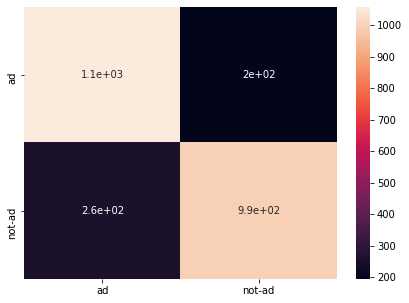

In [14]:
idx2class = {v: k for k, v in data.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)